In [12]:
import os
import sys
sys.path.append('../')
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from tempfile import gettempdir
from kwave.ksource import kSource
from kwave.kspaceFirstOrder2D import kspaceFirstOrder2DC
from kwave.utils import *
from kwave.ktransducer import *
from kwave.kmedium import kWaveMedium

os.environ["CUDA_VISIBLE_DEVICES"] = '1'

%matplotlib inline

In [13]:
IP_pad = np.zeros((2552, 2552))
IP_pad[1276, 1276] = 1

In [14]:
pathname = gettempdir()

PML_size = 4 # 12                               # Size of the PML in grid points.
Nx, Ny = IP_pad.shape
R_ring = 0.05                               # Radius of the ring array [m].
dx, dy = 4.e-5, 4.e-5                       # Grid point spacing in the y direction [m].
T_sample = 1/80e6                           # Sample time step [s].

N_transducer = 512                          # Number of transducers in ring array.
center_pos = [0, 0]
arc_angle = 2 * np.pi
kgrid = kWaveGrid([Nx, Ny], [dx, dy])

In [15]:
v0= 1500.0
SoS = np.ones((Ny, Nx)) * v0
rou = 1000  # Density.
medium = kWaveMedium(sound_speed=SoS, sound_speed_ref=v0, density=rou)

In [16]:
source = kSource()
source.p0 = IP_pad

# Smooth the initial pressure distribution and restore the magnitude.
# source.p0 = smooth(source.p0, True)

cart_sensor_mask = makeCartCircle(R_ring, N_transducer, center_pos, arc_angle)
sensor = kSensor(cart_sensor_mask) # Assign to sensor structure.

# Create the time array.
kgrid.makeTime(medium.sound_speed)
kgrid.setTime(4000, T_sample) ##

# Set the input arguements: force the PML to be outside the computational grid switch off p0 smoothing within kspaceFirstOrder2D.
input_args = {
    'PMLInside': False,
    'PMLSize': PML_size,
    'Smooth': False,
    'SaveToDisk': os.path.join(pathname, f'example_input.h5'),
    'SaveToDiskExit': False,
}

# Run the simulation.
sensor_data = kspaceFirstOrder2DC(**{
    'medium': medium,
    'kgrid': kgrid,
    'source': source,
    'sensor': sensor,
    **input_args
})

print(sensor_data.shape)

  start time: 12-Nov-2023-16-54-20
Running k-Wave simulation...
  start time: 12-Nov-2023-16-54-20
  reference sound speed:  1500.0 m/s
  reference sound speed:  1500.0 m/s
  dt:  12.5ns , t_end: 49.9875us , time steps: 4000
  input grid size: 2552 by 2552 grid points (102.08 by 102.08 m)
  maximum supported frequency:  18.75M Hz
  expanding computational grid...
  computational grid size: 2560 by 2560 grid points
  precomputation completed in  0.2981997560709715 s
  saving input files to disk...


In [ ]:
sensor_data = sensor_data[:,::2]
EIR = sensor_data[100:101,:]
sinogram_ft = np.fft.fft(EIR, axis=1)

/home/tianaoli/.conda/envs/pact/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Text(0.5, 1.0, 'EIR')

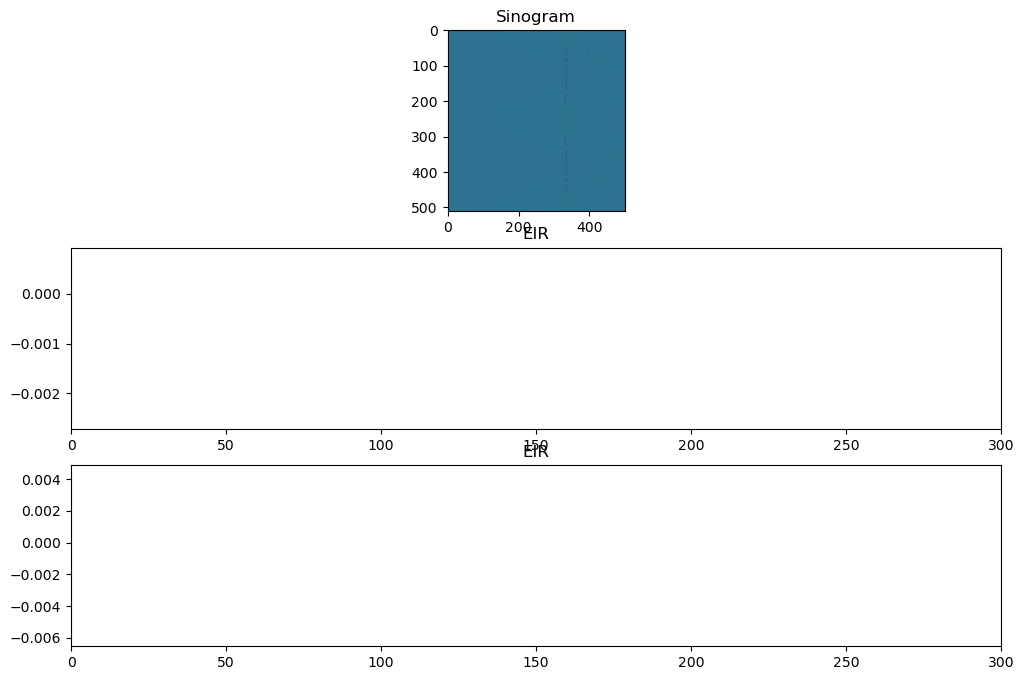

In [ ]:
plt.figure(figsize=(12,8))
plt.subplot(3,1,1)
plt.imshow(sensor_data)
plt.title('Sinogram')

plt.subplot(3,1,2)
plt.plot(EIR)
plt.xlim(0, 300)
plt.title('EIR')

plt.subplot(3,1,3)
plt.plot(sinogram_ft)
plt.xlim(0, 300)
plt.title('EIR')